Local Ollama LLM MCP TEST

In [ ]:
# Import annotations and typeddictionary
from typing import TypedDict, Annotated, Sequence
from dotenv import load_dotenv

# Import langchain model initilization
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END

# Import tools library
from langchain_core.tools import tool

# Import Langchain BaseMessage, AIMessage, ToolMessage
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage

# Import ToolNode
from langgraph.prebuilt import ToolNode

# Import reducer/merger function to append to state
from langgraph.graph.message import add_messages

# Import MCP for testing
from langchain_mcp_adapters.client import MultiServerMCPClient

# import asynchronous functions
import asyncio

# Initialze offline LLM
ollama_model = init_chat_model("ollama:llama3.2:latest")

# Define AgentState
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    
# Define list of MCP servers
client = MultiServerMCPClient(
    {
        "Chrome-MCP-Server": {
            "url": "http://127.0.0.1:12306/mcp",
            "transport": "streamable_http",
        }
    }
)

mcp_tools = await client.get_tools()
#print(mcp_tools)

ollama_mcp = ollama_model.bind_tools(mcp_tools)

async def model_call(state:AgentState) -> AgentState:
    system_prompt = SystemMessage(content="Your Name is Gideon, You have a set of tools connected to a Chrome MCP Server which can open webpages, Take screenshots, Add Bookmarks, delete Bookmarks and a lot more use these tools when necessary otherwise answer the question")
    response = ollama_mcp.invoke([system_prompt] + state["messages"])
    return {"messages": [response]}

# Conditional edge function
def should_continue(state:AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"
    
graph = StateGraph(AgentState)
graph.add_node("Gideon", model_call)

# Set Tool Node
tool_node = ToolNode(tools=mcp_tools)

graph.add_node("Tools", tool_node)

# Set Starting Point
graph.set_entry_point("Gideon")

# Add Conditional Edge
graph.add_conditional_edges(
    "Gideon",
    should_continue,
    {
        "continue": "Tools",
        "end": END,
    },
)

graph.add_edge("Tools", "Gideon")

app = graph.compile()

input_state = {"messages": [HumanMessage(content="Hello Gideon!, Open Youtube on google chrome on a new tab and also add a bookmark called as HeroOfTheWest!")]}
result = await app.ainvoke(input_state)

print(result["messages"][-1].content)

Session termination failed: 400
Session termination failed: 400


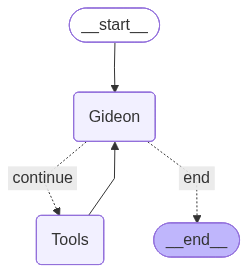

In [24]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.prebuilt import create_react_agent
client = MultiServerMCPClient(
    {
        "Chrome-MCP-Server": {
            "url": "http://127.0.0.1:12306/mcp",
            "transport": "streamable_http",
        }
    }
)

In [5]:
tools_mcp = await client.get_tools()
print(tools_mcp)

Session termination failed: 400


[StructuredTool(name='get_windows_and_tabs', description='Get all currently open browser windows and tabs', args_schema={'type': 'object', 'properties': {}, 'required': []}, response_format='content_and_artifact', coroutine=<function convert_mcp_tool_to_langchain_tool.<locals>.call_tool at 0x00000230FF53E480>), StructuredTool(name='chrome_navigate', description='Navigate to a URL or refresh the current tab', args_schema={'type': 'object', 'properties': {'url': {'type': 'string', 'description': 'URL to navigate to the website specified'}, 'newWindow': {'type': 'boolean', 'description': 'Create a new window to navigate to the URL or not. Defaults to false'}, 'width': {'type': 'number', 'description': 'Viewport width in pixels (default: 1280)'}, 'height': {'type': 'number', 'description': 'Viewport height in pixels (default: 720)'}, 'refresh': {'type': 'boolean', 'description': 'Refresh the current active tab instead of navigating to a URL. When true, the url parameter is ignored. Default

In [13]:
agent = create_react_agent(
    ollama_model,
    tools_mcp
)
chrome_response = await agent.ainvoke(
    {"messages": "Add a new bookmark named mcp"} # Navigation and creation of new window works! Tried with Google Maps! # take a screenshot works but limited by google api # add a new bookmark works!

)
print(chrome_response)

Session termination failed: 400


{'messages': [HumanMessage(content='Add a new bookmark named mcp', additional_kwargs={}, response_metadata={}, id='aac345b7-6284-4f0e-9b63-9fcb1c608820'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:latest', 'created_at': '2025-08-23T10:19:59.8820921Z', 'done': True, 'done_reason': 'stop', 'total_duration': 4553511800, 'load_duration': 174482300, 'prompt_eval_count': 2833, 'prompt_eval_duration': 2874038400, 'eval_count': 35, 'eval_duration': 1501807000, 'model_name': 'llama3.2:latest'}, id='run--fca292f8-82ef-41ef-9870-d815d90f37b5-0', tool_calls=[{'name': 'chrome_bookmark_add', 'args': {'createFolder': False, 'parentId': '', 'title': 'mcp', 'url': ''}, 'id': '247b380d-6740-4b97-b840-f37c0e07d0e3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2833, 'output_tokens': 35, 'total_tokens': 2868}), ToolMessage(content='{"status":"success","message":"Tool executed successfully","data":{"content":[{"type":"text","text":"{\\n  \\"success\\": true

In [6]:
load_dotenv(".env", override = True)

agent = create_react_agent(
    "groq:llama-3.1-8b-instant",
    tools_mcp
)
chrome_response = await agent.ainvoke(
    {"messages": "Play thick of it song on youtube from KSI"}
)

Session termination failed: 400
Session termination failed: 400
Session termination failed: 400


APIStatusError: Error code: 413 - {'error': {'message': 'Request too large for model `llama-3.1-8b-instant` in organization `org_01jqdvdktxefwb699chevnkj00` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Requested 88591, please reduce your message size and try again. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}